In [38]:
# Colab用：最初に一度だけ実行してください
!pip install -q foolbox==3.3.3 torch torchvision tqdm pillow


In [6]:
import shutil
from pathlib import Path

# === ベースディレクトリ ===
BASE_PATH = Path(r"C:\Users\sit\wavelet_CGAN\test") 

# === データセット（data1, data2, data3 から選択）===
datasets = ["data1", "data2"]

# === 攻撃タイプ ===
attacks = ["FGSM", "CW"]

# === 作成するフォルダ一覧をまとめる ===
dirs = []

for ds in datasets:
    # 元画像フォルダ
    dirs.append(BASE_PATH / ds)

    for atk in attacks:
        atk_base = BASE_PATH / f"{ds}_{atk}"
        dirs.append(atk_base)                 # 例: data1_FGSM
        dirs.append(atk_base / "noise")       # ノイズ可視化
        dirs.append(atk_base / "tensor")      # 攻撃後 .pt

# === 共通フォルダ ===
common_dirs = [
    BASE_PATH / "wavelet_tensor",
    BASE_PATH / "pix2pix_train_v2",
    BASE_PATH / "cgan_restore_failed",
    BASE_PATH / "results"
]

dirs.extend(common_dirs)

# === フォルダ作成 ===
for d in dirs:
    d.mkdir(parents=True, exist_ok=True)

# === 確認出力 ===
print("✅ 選択したデータセットに基づいてフォルダを作成しました:\n")
print("データセット:", datasets)
print("攻撃タイプ:", attacks)
print("\n作成フォルダ一覧:")
for d in dirs:
    print(" -", d)


✅ 選択したデータセットに基づいてフォルダを作成しました:

データセット: ['data1', 'data2']
攻撃タイプ: ['FGSM', 'CW']

作成フォルダ一覧:
 - C:\Users\sit\wavelet_CGAN\test\data1
 - C:\Users\sit\wavelet_CGAN\test\data1_FGSM
 - C:\Users\sit\wavelet_CGAN\test\data1_FGSM\noise
 - C:\Users\sit\wavelet_CGAN\test\data1_FGSM\tensor
 - C:\Users\sit\wavelet_CGAN\test\data1_CW
 - C:\Users\sit\wavelet_CGAN\test\data1_CW\noise
 - C:\Users\sit\wavelet_CGAN\test\data1_CW\tensor
 - C:\Users\sit\wavelet_CGAN\test\data2
 - C:\Users\sit\wavelet_CGAN\test\data2_FGSM
 - C:\Users\sit\wavelet_CGAN\test\data2_FGSM\noise
 - C:\Users\sit\wavelet_CGAN\test\data2_FGSM\tensor
 - C:\Users\sit\wavelet_CGAN\test\data2_CW
 - C:\Users\sit\wavelet_CGAN\test\data2_CW\noise
 - C:\Users\sit\wavelet_CGAN\test\data2_CW\tensor
 - C:\Users\sit\wavelet_CGAN\test\wavelet_tensor
 - C:\Users\sit\wavelet_CGAN\test\pix2pix_restore_train_v2
 - C:\Users\sit\wavelet_CGAN\test\cgan_restore_failed
 - C:\Users\sit\wavelet_CGAN\test\results


In [1]:
import os
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from pathlib import Path

# === ベースパス ===
BASE_PATH = Path(r"C:/Users/sit/wavelet_CGAN/test")

# === 🔸 ここで処理したいデータセットを選択 ===
datasets = ["data1", "data2"]   # ← 必要に応じて ["data1"], ["data2","data3"] etc.

# === transform（AE生成前と整合） ===
to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # [0,1]
])

for ds in datasets:
    input_dir = BASE_PATH / ds
    output_dir = BASE_PATH / f"{ds}_tensor"

    output_dir.mkdir(parents=True, exist_ok=True)

    print(f"\n=== {ds} の Tensor 化を開始 ===")

    for fname in tqdm(sorted(os.listdir(input_dir))):
        if not fname.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = input_dir / fname
        img = Image.open(img_path).convert("RGB")

        tensor = to_tensor(img).unsqueeze(0)  # [1,3,H,W]
        save_path = output_dir / (Path(fname).stem + ".pt")

        torch.save(tensor, save_path)

    print(f"✅ {ds} → Tensor 化完了: {output_dir}")

print("\n🎉 全データセットの Tensor 変換が完了しました！")



=== data1 の Tensor 化を開始 ===


100%|██████████| 1002/1002 [00:05<00:00, 181.85it/s]


✅ data1 → Tensor 化完了: C:\Users\sit\wavelet_CGAN\test\data1_tensor

=== data2 の Tensor 化を開始 ===


100%|██████████| 1002/1002 [00:05<00:00, 184.24it/s]

✅ data2 → Tensor 化完了: C:\Users\sit\wavelet_CGAN\test\data2_tensor

🎉 全データセットの Tensor 変換が完了しました！


# FGSM + CW Attack

In [14]:
# ==========================================================
# ① FGSM + CW Attack（Jupyter統一版・前処理 Normalize のみ）
#    - MobileNetV2(IMAGENET1K_V1) + NormalizeModule + bounds=(0,1)
#    - 画像前処理: Resize(224,224) + ToTensor() （※Normalizeはモデル側）
# ==========================================================
import os, re, torch, numpy as np, pandas as pd
import torchvision.transforms as T
from torchvision import models
from torch.nn import functional as F
from PIL import Image
from pathlib import Path
from tqdm import tqdm
import foolbox as fb
import torch.nn as nn

# ----------------------------
# 設定
# ----------------------------
BASE     = Path(r"C:\Users\sit\wavelet_CGAN\test")
datasets = ["data1", "data2"]      # 必要に応じて変更
choice   = "FGSM"                  # "FGSM" / "CW" / "BOTH"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# 画像前処理（Resize+ToTensorだけ）
# ----------------------------
transform_base = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()             # [0,1]
])

# ----------------------------
# MobileNetV2 + NormalizeModule
# ----------------------------
weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
mobilenetv2 = models.mobilenet_v2(weights=weights).to(device).eval()

if "mean" in weights.meta and "std" in weights.meta:
    MEAN, STD = weights.meta["mean"], weights.meta["std"]
else:
    tinfo = weights.transforms()
    MEAN, STD = tinfo.mean, tinfo.std

class NormalizeModule(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", torch.tensor(mean).view(1,3,1,1))
        self.register_buffer("std",  torch.tensor(std).view(1,3,1,1))
    def forward(self, x):
        return (x - self.mean) / self.std

model = nn.Sequential(NormalizeModule(MEAN, STD), mobilenetv2).to(device).eval()
fmodel = fb.PyTorchModel(model, bounds=(0.0, 1.0))

# クラス名は weights.meta から（Jupyter側と合わせる）
IMAGENET_CLS = weights.meta["categories"]

def pred(images, topk=1):
    with torch.no_grad():
        logits = model(images.to(device))
        probs  = F.softmax(logits, dim=1)
        top_p, top_i = torch.topk(probs, topk)
        idx = int(top_i[0,0].item())
        return idx, IMAGENET_CLS[idx], float(top_p[0,0].cpu().item())

def extract_number(p: Path):
    m = re.search(r"\d+", p.stem)
    return int(m.group()) if m else float("inf")

# ----------------------------
# FGSM （ε線形サーチ）
# ----------------------------
def perform_attack_fgsm(fmodel_local, images, labels, steps=1000, max_eps=1.0):
    attack = fb.attacks.FGSM()
    eps = 0.0
    for _ in range(steps):
        eps += max_eps / steps
        raw, clipped, is_adv = attack(fmodel_local, images, labels, epsilons=[eps])

        if isinstance(clipped, (list, tuple)):
            clipped = clipped[0]

        adv_t = torch.as_tensor(clipped).float().cpu()
        if adv_t.dim() == 3:
            adv_t = adv_t.unsqueeze(0)
        adv_t = adv_t.clamp(0,1)

        adv_idx, _, _  = pred(adv_t.to(device))
        orig_idx, _, _ = pred(images)

        if adv_idx != orig_idx:
            return adv_t, eps, adv_idx
    orig_idx, _, _ = pred(images)
    return None, eps, orig_idx

def attack_FGSM(ds_name):
    print(f"\n🚀 FGSM攻撃開始 ({ds_name})")

    DATA_DIR   = BASE / ds_name
    OUT_DIR    = BASE / f"{ds_name}_FGSM"
    TENSOR_DIR = OUT_DIR / "tensor"
    NOISE_DIR  = OUT_DIR / "noise"  # 必要ならあとで使用

    for p in [OUT_DIR, TENSOR_DIR, NOISE_DIR]:
        p.mkdir(parents=True, exist_ok=True)

    AE_results = []
    imgs = sorted(
        [f for f in DATA_DIR.iterdir() if f.suffix.lower() in [".jpg",".jpeg",".png"]],
        key=extract_number
    )

    for i, path in enumerate(tqdm(imgs, desc=f"FGSM Attack ({ds_name})")):
        img = Image.open(path).convert("RGB")
        images = transform_base(img).unsqueeze(0).to(device)

        orig_idx, orig_name, orig_conf = pred(images)
        labels = torch.tensor([orig_idx], dtype=torch.long, device=device)

        adv, eps, adv_idx = perform_attack_fgsm(fmodel, images, labels)

        if adv is not None:
            adv_idx, adv_name, adv_conf = pred(adv.to(device))
            torch.save(adv.cpu(), TENSOR_DIR / f"{path.stem}.pt")

            AE_results.append({
                "image": path.name,
                "Original_label": orig_idx,
                "Original_label_name": orig_name,
                "Original_confidence": orig_conf,
                "Advs_label": adv_idx,
                "Advs_label_name": adv_name,
                "Advs_confidence": adv_conf,
                "Eps": eps,
            })

    pd.DataFrame(AE_results).to_csv(
        OUT_DIR / "FGSM_Results.csv",
        index=False, encoding="utf-8-sig"
    )
    print(f"✅ FGSM完了 → {OUT_DIR}")

# ----------------------------
# CW（L2-CarliniWagner）
# ----------------------------
def attack_CW(ds_name):
    print(f"\n🚀 CW攻撃開始 ({ds_name})")

    DATA_DIR   = BASE / ds_name
    OUT_DIR    = BASE / f"{ds_name}_CW"
    TENSOR_DIR = OUT_DIR / "tensor"
    NOISE_DIR  = OUT_DIR / "noise"

    for p in [TENSOR_DIR, NOISE_DIR]:
        p.mkdir(parents=True, exist_ok=True)

    AE_results = []
    attack = fb.attacks.L2CarliniWagnerAttack(
        steps=100,
        binary_search_steps=10,
        confidence=0.0
    )

    imgs = sorted(
        [f for f in DATA_DIR.iterdir() if f.suffix.lower() in [".jpg",".jpeg",".png"]],
        key=extract_number
    )

    for i, path in enumerate(tqdm(imgs, desc=f"CW Attack ({ds_name})")):
        img = Image.open(path).convert("RGB")
        images = transform_base(img).unsqueeze(0).to(device)

        orig_idx, orig_name, orig_conf = pred(images)
        labels = torch.tensor([orig_idx], dtype=torch.long, device=device)

        raw, adv, is_adv = attack(fmodel, images, labels, epsilons=None)

        if isinstance(adv, (list, tuple)):
            adv = adv[0]

        adv_t = torch.as_tensor(adv).float().cpu()
        if adv_t.dim() == 3:
            adv_t = adv_t.unsqueeze(0)
        adv_t = adv_t.clamp(0,1)

        adv_idx, adv_name, adv_conf = pred(adv_t.to(device))

        l2 = torch.norm(
            (images.cpu() - adv_t).view(1, -1),
            p=2
        ).item()

        torch.save(adv_t.cpu(), TENSOR_DIR / f"{path.stem}.pt")

        AE_results.append({
            "image": path.name,
            "Original_label": orig_idx,
            "Original_label_name": orig_name,
            "Original_confidence": orig_conf,
            "Advs_label": adv_idx,
            "Advs_label_name": adv_name,
            "Advs_confidence": adv_conf,
            "L2_Distance": l2,
        })

    pd.DataFrame(AE_results).to_csv(
        OUT_DIR / "CW_Results.csv",
        index=False, encoding="utf-8-sig"
    )
    print(f"✅ CW完了 → {OUT_DIR}")

# ----------------------------
# 実行
# ----------------------------
for ds in datasets:
    if choice == "FGSM":
        attack_FGSM(ds)
    elif choice == "CW":
        attack_CW(ds)
    elif choice == "BOTH":
        attack_FGSM(ds)
        attack_CW(ds)
    else:
        print("⚠ choice を 'FGSM' / 'CW' / 'BOTH' にしてください。")



🚀 FGSM攻撃開始 (data1)


FGSM Attack (data1): 100%|██████████| 1000/1000 [02:53<00:00,  5.78it/s]


✅ FGSM完了 → C:\Users\sit\wavelet_CGAN\test\data1_FGSM

🚀 FGSM攻撃開始 (data2)


FGSM Attack (data2): 100%|██████████| 1000/1000 [02:25<00:00,  6.85it/s]

✅ FGSM完了 → C:\Users\sit\wavelet_CGAN\test\data2_FGSM


# Wavelet変換

In [15]:
# ==========================================================
# ② Wavelet分類回復（Jupyter統一版）
#  - 入力: BASE / {dataset}_{attack}/tensor/*.pt
#  - 出力: BASE / {dataset}_{attack}/wavelet_eval/
# ==========================================================
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models
from torchvision.utils import save_image
import numpy as np
import pandas as pd
import pywt
from pathlib import Path
from tqdm import tqdm

# ----------------------------
# 設定
# ----------------------------
BASE     = Path(r"C:\Users\sit\wavelet_CGAN\test")
dataset  = "data2"          # "data1" / "data2" / "data3"
choice   = "BOTH"           # "FGSM" / "CW" / "BOTH"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Waveletノイズ除去
# ----------------------------
def wavelet_denoise(img_tensor, wavelet="haar", level=1, threshold=0.07):
    if img_tensor.ndim == 3:
        img_tensor = img_tensor.unsqueeze(0)

    img_np = img_tensor.detach().cpu().numpy()
    denoised = []

    for b in range(img_np.shape[0]):
        channels = []
        for c in range(img_np.shape[1]):
            coeffs = pywt.wavedec2(img_np[b, c], wavelet=wavelet, level=level)
            cA = coeffs[0]
            cD = coeffs[1:]

            cD_th = []
            for (cH, cV, cD_) in cD:
                cH = pywt.threshold(cH, threshold * np.max(np.abs(cH)))
                cV = pywt.threshold(cV, threshold * np.max(np.abs(cV)))
                cD_ = pywt.threshold(cD_, threshold * np.max(np.abs(cD_)))
                cD_th.append((cH, cV, cD_))

            coeffs_f = [cA] + cD_th
            rec = pywt.waverec2(coeffs_f, wavelet)
            rec = rec[:img_np.shape[2], :img_np.shape[3]]
            channels.append(rec)

        denoised.append(np.stack(channels))

    denoised = np.stack(denoised)
    return torch.tensor(denoised).float().clamp(0, 1)

# ----------------------------
# MobileNetV2（Normalizeのみ）
# ----------------------------
def load_classifier(device):
    weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
    model   = models.mobilenet_v2(weights=weights).to(device).eval()

    if "mean" in weights.meta and "std" in weights.meta:
        mean, std = weights.meta["mean"], weights.meta["std"]
    else:
        tinfo = weights.transforms()
        mean, std = tinfo.mean, tinfo.std

    mean = torch.tensor(mean).view(1,3,1,1).to(device)
    std  = torch.tensor(std).view(1,3,1,1).to(device)

    def preprocess(x_01):
        return (x_01 - mean) / std

    imagenet_classes = weights.meta["categories"]
    return model, preprocess, imagenet_classes

def predict(model, img_tensor, preprocess, imagenet_classes):
    with torch.no_grad():
        x = preprocess(img_tensor.to(device))
        logits = model(x)
        probs  = F.softmax(logits, dim=1)
        conf, idx = probs.max(1)
        idx = int(idx.item())
        return idx, imagenet_classes[idx], float(conf.item())

# ----------------------------
# Wavelet分類本体
# ----------------------------
def process_wavelet(dataset, attack_type):
    attack_dir = BASE / f"{dataset}_{attack_type}"
    tensor_dir = attack_dir / "tensor"          # 攻撃後 .pt
    out_root   = attack_dir / "wavelet_eval"
    out_tensor = out_root / "tensor_out"
    out_image  = out_root / "image_out"

    out_root.mkdir(parents=True, exist_ok=True)
    out_tensor.mkdir(exist_ok=True)
    out_image.mkdir(exist_ok=True)

    print(f"\n=== Wavelet分類 ({dataset}_{attack_type}) ===")
    print(f"入力: {tensor_dir}")

    clf, preprocess, classes = load_classifier(device)
    results = []

    files = sorted([f for f in os.listdir(tensor_dir) if f.endswith(".pt")])

    for fname in tqdm(files):
        path = tensor_dir / fname
        x = torch.load(path, map_location=device)
        if x.ndim == 3:
            x = x.unsqueeze(0)

        x_w = wavelet_denoise(x).to(device).clamp(0,1)

        idx, name, conf = predict(clf, x_w, preprocess, classes)

        base = Path(fname).stem
        torch.save(x_w.cpu(), out_tensor / f"{base}_wavelet.pt")
        save_image(x_w.cpu(), out_image / f"{base}_wavelet.png")

        results.append({
            "ImageId": base,
            "Wavelet_Label": name,
            "Wavelet_Confidence": round(conf, 6)
        })

    csv_path = out_root / f"{dataset}_{attack_type}_Wavelet_class_results.csv"
    pd.DataFrame(results).to_csv(csv_path, index=False, encoding="utf-8-sig")
    print(f"✅ Wavelet分類結果CSV: {csv_path}")

# ----------------------------
# 実行
# ----------------------------
if choice in ["FGSM", "BOTH"]:
    process_wavelet(dataset, "FGSM")
if choice in ["CW", "BOTH"]:
    process_wavelet(dataset, "CW")



=== Wavelet分類 (data2_FGSM) ===
入力: C:\Users\sit\wavelet_CGAN\test\data2_FGSM\tensor


100%|██████████| 1000/1000 [00:30<00:00, 32.81it/s]


✅ Wavelet分類結果CSV: C:\Users\sit\wavelet_CGAN\test\data2_FGSM\wavelet_eval\data2_FGSM_Wavelet_class_results.csv

=== Wavelet分類 (data2_CW) ===
入力: C:\Users\sit\wavelet_CGAN\test\data2_CW\tensor


100%|██████████| 1000/1000 [00:30<00:00, 33.03it/s]

✅ Wavelet分類結果CSV: C:\Users\sit\wavelet_CGAN\test\data2_CW\wavelet_eval\data2_CW_Wavelet_class_results.csv


In [16]:
# ==========================================================
# 攻撃前＋攻撃後＋Wavelet分類結果の統合＆成功判定（ローカル対応版）
# ==========================================================
import pandas as pd
from pathlib import Path

# ==========================================================
# === 設定（ここだけ変えればOK）===
# ==========================================================
choice  = "BOTH"     # "FGSM" / "CW" / "BOTH"
dataset = "data2"    # data1 / data2 / data3

# ★ あなたのPCの実際のパスに合わせる
base_root = Path(r"C:\Users\sit\wavelet_CGAN\test")

print("\n=== 3段階CSV統合処理開始 ===")


# ==========================================================
# === メイン処理関数 ===
# ==========================================================
def process_comparison(dataset, attack_type):

    print(f"\n==============================")
    print(f"=== {dataset} / {attack_type} 統合処理開始 ===")
    print(f"==============================\n")

    # ======================================================
    # ★ CSV パス（Wavelet は dataset_attack_type に合わせる）
    # ======================================================
    before_csv   = base_root / dataset / "clean_dataset_labels.csv"
    after_csv    = base_root / f"{dataset}_{attack_type}" / f"{attack_type}_Results.csv"

    # ★ 修正点：Wavelet は data1_FGSM_Wavelet_class_results.csv を参照
    wavelet_csv  = (
        base_root
        / f"{dataset}_{attack_type}"
        / "wavelet_eval"
        / f"{dataset}_{attack_type}_Wavelet_class_results.csv"
    )

    output_csv   = base_root / f"{dataset}_{attack_type}" / "wavelet_eval" / f"{dataset}_{attack_type}_All_Compare.csv"
    success_csv  = base_root / f"{dataset}_{attack_type}" / "wavelet_eval" / f"{dataset}_{attack_type}_RecoverySuccessOnly.csv"

    print(f"[攻撃前 CSV]         {before_csv}")
    print(f"[攻撃後 CSV]         {after_csv}")
    print(f"[Wavelet結果 CSV]    {wavelet_csv}\n")

    # === CSV 読み込み ===
    df_before = pd.read_csv(before_csv)
    df_after  = pd.read_csv(after_csv)
    df_wave   = pd.read_csv(wavelet_csv)

    # ======================================================
    # ImageId 統一
    # ======================================================
    if "image" in df_before.columns:
        df_before["ImageId"] = df_before["image"].apply(lambda x: Path(str(x)).stem)

    if "image" in df_after.columns:
        df_after["ImageId"] = df_after["image"].apply(lambda x: Path(str(x)).stem)
    else:
        df_after["ImageId"] = df_after.iloc[:, 0].apply(lambda x: Path(str(x)).stem)

    # ======================================================
    # 列名統一
    # ======================================================
    if "label_name" in df_before.columns:
        df_before = df_before.rename(columns={"label_name": "label_name_before"})
    if "confidence" in df_before.columns:
        df_before = df_before.rename(columns={"confidence": "confidence_before"})

    df_after = df_after.rename(columns={
        "Advs_label_name": "label_name_after",
        "Advs_confidence": "confidence_after"
    })

    # ======================================================
    # 結合
    # ======================================================
    df_merged = df_before.merge(df_after, on="ImageId")
    df_merged = df_merged.merge(df_wave, on="ImageId", how="left")

    # ======================================================
    # 成功判定
    # ======================================================
    df_merged["AttackSuccess"]   = df_merged["label_name_before"] != df_merged["label_name_after"]
    df_merged["RecoverySuccess"] = df_merged["label_name_before"] == df_merged["Wavelet_Label"]

    # ======================================================
    # 必要列のみ抽出
    # ======================================================
    cols_order = [
        "ImageId",
        "label_name_before", "confidence_before",
        "label_name_after",  "confidence_after",
        "Wavelet_Label",     "Wavelet_Confidence",
        "AttackSuccess", "RecoverySuccess"
    ]

    df_final = df_merged[cols_order]

    # ======================================================
    # 保存
    # ======================================================
    df_final.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"✅ 統合CSV 出力 → {output_csv}")

    total = len(df_final)
    atk_succ = df_final["AttackSuccess"].sum()
    rec_succ = df_final["RecoverySuccess"].sum()

    print(f"\n📊 統計（{attack_type}）")
    print(f"- 攻撃成功    : {atk_succ}/{total} ({atk_succ/total*100:.2f}%)")
    print(f"- 矯正成功    : {rec_succ}/{total} ({rec_succ/total*100:.2f}%)\n")

    df_success = df_final[df_final["RecoverySuccess"] == True]
    df_success.to_csv(success_csv, index=False, encoding="utf-8-sig")
    print(f"🎉 矯正成功のみ → {success_csv}\n")


# ==========================================================
# === 実行 ===
# ==========================================================
if choice == "FGSM":
    process_comparison(dataset, "FGSM")
elif choice == "CW":
    process_comparison(dataset, "CW")
elif choice == "BOTH":
    process_comparison(dataset, "FGSM")
    process_comparison(dataset, "CW")
else:
    print("⚠ choice を 'FGSM' / 'CW' / 'BOTH' から選択してください。")



=== 3段階CSV統合処理開始 ===

=== data2 / FGSM 統合処理開始 ===

[攻撃前 CSV]         C:\Users\sit\wavelet_CGAN\test\data2\clean_dataset_labels.csv
[攻撃後 CSV]         C:\Users\sit\wavelet_CGAN\test\data2_FGSM\FGSM_Results.csv
[Wavelet結果 CSV]    C:\Users\sit\wavelet_CGAN\test\data2_FGSM\wavelet_eval\data2_FGSM_Wavelet_class_results.csv

✅ 統合CSV 出力 → C:\Users\sit\wavelet_CGAN\test\data2_FGSM\wavelet_eval\data2_FGSM_All_Compare.csv

📊 統計（FGSM）
- 攻撃成功    : 1000/1000 (100.00%)
- 矯正成功    : 810/1000 (81.00%)

🎉 矯正成功のみ → C:\Users\sit\wavelet_CGAN\test\data2_FGSM\wavelet_eval\data2_FGSM_RecoverySuccessOnly.csv


=== data2 / CW 統合処理開始 ===

[攻撃前 CSV]         C:\Users\sit\wavelet_CGAN\test\data2\clean_dataset_labels.csv
[攻撃後 CSV]         C:\Users\sit\wavelet_CGAN\test\data2_CW\CW_Results.csv
[Wavelet結果 CSV]    C:\Users\sit\wavelet_CGAN\test\data2_CW\wavelet_eval\data2_CW_Wavelet_class_results.csv

✅ 統合CSV 出力 → C:\Users\sit\wavelet_CGAN\test\data2_CW\wavelet_eval\data2_CW_All_Compare.csv

📊 統計（CW）
- 攻撃成功    : 1000/

In [17]:
from pathlib import Path
import os

# ベースディレクトリ
base_root = Path(r"C:\Users\sit\wavelet_CGAN\test")

# weights フォルダの作成
weights_dir = base_root / "weights"
weights_dir.mkdir(exist_ok=True)

print("✅ weightsフォルダを作成しました:")
print(weights_dir)

# 既存ファイル一覧も確認
print("\n📂 現在の wavelet_CGAN\\test 内:")
for item in base_root.iterdir():
    print(" -", item.name)


✅ weightsフォルダを作成しました:
C:\Users\sit\wavelet_CGAN\test\weights

📂 現在の wavelet_CGAN\test 内:
 - cgan_restore_failed
 - compare_data1_CW_Wavelet_CGAN.csv
 - compare_data1_FGSM_Wavelet_CGAN.csv
 - compare_data2_CW_Wavelet_CGAN.csv
 - compare_data2_FGSM_Wavelet_CGAN.csv
 - data1
 - data1_CW
 - data1_FGSM
 - data1_tensor
 - data2
 - data2_CW
 - data2_FGSM
 - data2_tensor
 - pix2pix_restore
 - pix2pix_restore_train_v2
 - results
 - wavelet_tensor
 - weights


# Wavelet＋CGAN復元＋4段階比較＆成功率判定

In [20]:
# ==========================================================
# ③ Wavelet＋CGAN復元＋4段階比較＆成功率（Jupyter統一版）
#  - MobileNet前処理: Normalizeのみ（Resize/Cropなし）
# ==========================================================
import os
import sys
import torch
import torch.nn.functional as F
import pandas as pd
from pathlib import Path
from torchvision import models
from torchvision.utils import save_image
from torch import nn
from tqdm import tqdm

# ----------------------------
# 設定
# ----------------------------
BASE        = Path(r"C:\Users\sit\wavelet_CGAN\test")
dataset     = "data1"        # "data1" / "data2" / "data3"
attack_type = "FGSM"         # "FGSM" / "CW"

clean_dir   = BASE / dataset
adv_dir     = BASE / f"{dataset}_{attack_type}"
wavelet_dir = adv_dir / "wavelet_eval"
tensor_dir  = wavelet_dir / "tensor_out"   # *_wavelet.pt

cgan_out_dir    = BASE / "pix2pix_restore" / f"{dataset}_{attack_type}"
cgan_png_dir    = cgan_out_dir / "image_out"
cgan_tensor_dir = cgan_out_dir / "tensor_out"

for p in [cgan_out_dir, cgan_png_dir, cgan_tensor_dir]:
    p.mkdir(parents=True, exist_ok=True)

before_csv  = clean_dir  / "clean_dataset_labels.csv"
after_csv   = adv_dir    / f"{attack_type}_Results.csv"
wavelet_csv = wavelet_dir / f"{dataset}_{attack_type}_Wavelet_class_results.csv"
cgan_csv    = cgan_out_dir / f"pix2pix_class_results_{dataset}_{attack_type}.csv"
merged_csv  = BASE / f"compare_{dataset}_{attack_type}_Wavelet_CGAN.csv"

weight_path = BASE / "weights" / "gen_weights_epoch300.pth"

def _must_exist(p: Path):
    if not p.exists():
        print(f"[ERROR] Not found: {p}")
        sys.exit(1)

for p in [before_csv, after_csv, wavelet_csv, tensor_dir, weight_path]:
    _must_exist(p)

# ----------------------------
# MobileNetV2（Normalizeのみ）
# ----------------------------
def load_classifier(device):
    weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
    model   = models.mobilenet_v2(weights=weights).to(device).eval()
    classes = weights.meta["categories"]

    if "mean" in weights.meta and "std" in weights.meta:
        mean, std = weights.meta["mean"], weights.meta["std"]
    else:
        tinfo = weights.transforms()
        mean, std = tinfo.mean, tinfo.std

    mean = torch.tensor(mean).view(1,3,1,1).to(device)
    std  = torch.tensor(std).view(1,3,1,1).to(device)

    def preprocess(x_01):
        return (x_01 - mean) / std

    return model, preprocess, classes

# ----------------------------
# UNet Generator (pix2pix)
# ----------------------------
class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=64):
        super().__init__()
        self.encoder = nn.Sequential(
            self.block(in_channels, features, normalize=False),
            self.block(features, features * 2),
            self.block(features * 2, features * 4),
            self.block(features * 4, features * 8),
            self.block(features * 8, features * 8),
        )
        self.decoder = nn.Sequential(
            self.upblock(features * 8, features * 8),
            self.upblock(features * 8 * 2, features * 4),
            self.upblock(features * 4 * 2, features * 2),
            self.upblock(features * 2 * 2, features),
            nn.ConvTranspose2d(features * 2, out_channels, 4, 2, 1),
            nn.Tanh(),
        )

    def block(self, in_c, out_c, normalize=True):
        layers = [nn.Conv2d(in_c, out_c, 4, 2, 1)]
        if normalize:
            layers.append(nn.BatchNorm2d(out_c))
        layers.append(nn.LeakyReLU(0.2))
        return nn.Sequential(*layers)

    def upblock(self, in_c, out_c):
        return nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def forward(self, x):
        skips = []
        for layer in self.encoder:
            x = layer(x); skips.append(x)
        skips = skips[:-1][::-1]
        for i, layer in enumerate(self.decoder[:-2]):
            x = layer(x)
            if i < len(skips):
                x = torch.cat([x, skips[i]], 1)
        return self.decoder[-2](x)

# ----------------------------
# CGAN復元＋分類
# ----------------------------
def restore_and_classify():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    gen = UNetGenerator().to(device)
    gen.load_state_dict(torch.load(weight_path, map_location=device))
    gen.eval()

    clf, preprocess, classes = load_classifier(device)

    results = []
    print(f"\n=== CGAN推論＋分類開始 ({dataset}/{attack_type}) ===\n")

    with torch.no_grad():
        for fname in tqdm(sorted(os.listdir(tensor_dir))):
            if not fname.endswith(".pt"):
                continue

            t = torch.load(tensor_dir / fname, map_location=device)   # [1,3,224,224] [0,1]
            if t.ndim == 3:
                t = t.unsqueeze(0)

            t_in = (t - 0.5) / 0.5  # [0,1] → [-1,1]
            restored = gen(t_in.to(device))
            restored_01 = (restored * 0.5 + 0.5).clamp(0,1)

            base = Path(fname).stem.replace("_wavelet", "")

            # PNG保存
            save_image(restored_01.cpu(), cgan_png_dir / f"{base}_{attack_type}_restored.png")
            # Tensor保存
            torch.save(restored_01.cpu(), cgan_tensor_dir / f"{base}_{attack_type}_restored.pt")

            # 分類
            x = restored_01.to(device)     # [1,3,224,224] 0〜1
            x = preprocess(x)              # Normalizeのみ
            preds = F.softmax(clf(x), dim=1)
            conf, idx = preds.max(1)
            idx = int(idx.item())

            results.append({
                "ImageId": base,
                "CGAN_Label": classes[idx],
                "CGAN_Confidence": float(conf.item()),
            })

    pd.DataFrame(results).to_csv(cgan_csv, index=False, encoding="utf-8-sig")
    print(f"✅ CGAN分類結果CSV: {cgan_csv}")

# ----------------------------
# 4段階統合
# ----------------------------
def merge_and_evaluate():
    print(f"\n=== 4段階CSV統合＆成功率 ({dataset}/{attack_type}) ===\n")

    df_b = pd.read_csv(before_csv)
    df_a = pd.read_csv(after_csv)
    df_w = pd.read_csv(wavelet_csv)
    df_g = pd.read_csv(cgan_csv)

    df_b["ImageId"] = df_b["image"].apply(lambda x: Path(str(x)).stem)
    df_a["ImageId"] = df_a["image"].apply(lambda x: Path(str(x)).stem)
    df_g["ImageId"] = df_g["ImageId"].astype(str)

    df_b = df_b.rename(columns={"label_name":"Original_Label",
                                "confidence":"Original_Confidence"})
    df_a = df_a.rename(columns={"Advs_label_name":"Adversarial_Label",
                                "Advs_confidence":"Adversarial_Confidence"})

    df = (df_b.merge(df_a, on="ImageId", how="inner")
              .merge(df_w, on="ImageId", how="left")
              .merge(df_g, on="ImageId", how="left"))

    df["AttackSuccess"]          = df["Original_Label"] != df["Adversarial_Label"]
    df["RecoverySuccess_Wavelet"]= df["Original_Label"] == df["Wavelet_Label"]
    df["RecoverySuccess_CGAN"]   = df["Original_Label"] == df["CGAN_Label"]

    cols = [
        "ImageId",
        "Original_Label", "Original_Confidence",
        "Adversarial_Label", "Adversarial_Confidence",
        "Wavelet_Label", "Wavelet_Confidence",
        "CGAN_Label", "CGAN_Confidence",
        "AttackSuccess", "RecoverySuccess_Wavelet", "RecoverySuccess_CGAN"
    ]
    df = df[[c for c in cols if c in df.columns]]
    df.to_csv(merged_csv, index=False, encoding="utf-8-sig")

    total = len(df)
    atk   = int(df["AttackSuccess"].sum())
    w_ok  = int(df["RecoverySuccess_Wavelet"].sum())
    g_ok  = int(df["RecoverySuccess_CGAN"].sum())
    pct   = lambda n: (n/total*100.0) if total else 0.0

    print("=== 統計結果 ===")
    print(f"総数: {total}")
    print(f"攻撃成功数:        {atk}/{total} ({pct(atk):.2f}%)")
    print(f"Wavelet矯正成功数: {w_ok}/{total} ({pct(w_ok):.2f}%)")
    print(f"CGAN矯正成功数:   {g_ok}/{total} ({pct(g_ok):.2f}%)")
    print(f"\n✅ 出力: {merged_csv}")

# ----------------------------
# 実行
# ----------------------------
if __name__ == "__main__":
    restore_and_classify()
    merge_and_evaluate()



=== CGAN推論＋分類開始 (data1/FGSM) ===



100%|██████████| 1000/1000 [00:42<00:00, 23.69it/s]

✅ CGAN分類結果CSV: C:\Users\sit\wavelet_CGAN\test\pix2pix_restore\data1_FGSM\pix2pix_class_results_data1_FGSM.csv

=== 4段階CSV統合＆成功率 (data1/FGSM) ===

=== 統計結果 ===
総数: 1000
攻撃成功数:        1000/1000 (100.00%)
Wavelet矯正成功数: 856/1000 (85.60%)
CGAN矯正成功数:   807/1000 (80.70%)

✅ 出力: C:\Users\sit\wavelet_CGAN\test\compare_data1_FGSM_Wavelet_CGAN.csv


# 評価・考察

In [17]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['IPAexGothic']


In [21]:
!sudo apt-get update
!sudo apt-get install -y fonts-noto-cjk


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,135 kB]
Get:13 https://cli.github.com/packages stable/main amd64 Packag

✔ 使用フォントパス: /usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc
📄 CSV: /content/wavelet_CGAN/compare_data1_CW_Wavelet_CGAN.csv
Wavelet : 38.0
CGAN    : 78.0


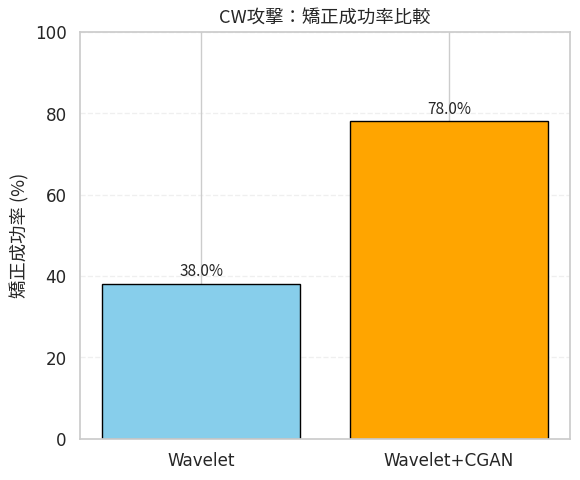

/tmp/ipython-input-470500086.py:116: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  wavelet_stats = df.groupby("Wavelet_bin")["RecoverySuccess_Wavelet"].mean().values * 100
/tmp/ipython-input-470500086.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cgan_stats    = df.groupby("CGAN_bin")   ["RecoverySuccess_CGAN"].mean().values * 100


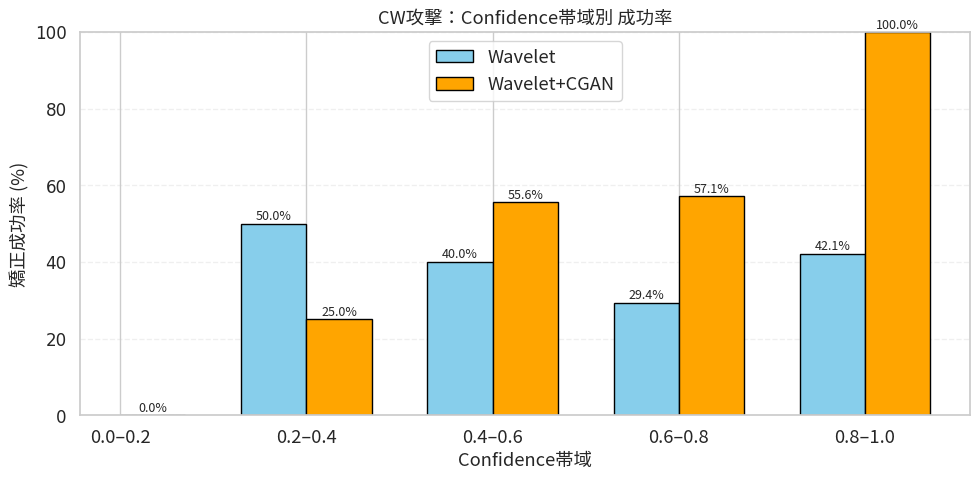

In [26]:
# =====================================================
# 📌 NotoSansCJK のパスを自動で検出して日本語フォント設定
# =====================================================
import matplotlib.font_manager as fm
import subprocess

# "NotoSansCJK-Regular.ttc" を検索
paths = subprocess.getoutput("fc-list | grep -i 'NotoSansCJK-Regular.ttc'").split("\n")

if len(paths) == 0:
    raise FileNotFoundError("NotoSansCJK-Regular.ttc が見つかりませんでした")

# 最初の1つを使用
font_path = paths[0].split(":")[0]

print("✔ 使用フォントパス:", font_path)

jp_font = fm.FontProperties(fname=font_path)

import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# 入力設定
# ----------------------------------------------------------
DATASET = "data1"
ATTACK  = "CW"

BASE = Path("/content/wavelet_CGAN")

CSV_PATHS = [
    BASE / f"compare_{DATASET}_{ATTACK}_Wavelet_CGAN.csv",
    BASE / "results" / f"compare_{DATASET}_{ATTACK}_Wavelet_CGAN.csv",
]

CSV_PATH = next((p for p in CSV_PATHS if p.exists()), None)
if CSV_PATH is None:
    raise FileNotFoundError("CSV not found")

print("📄 CSV:", CSV_PATH)

OUT_DIR = BASE / "results"
FIG_DIR = OUT_DIR / "figs"
OUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(exist_ok=True)

# ----------------------------------------------------------
# データ読み込み
# ----------------------------------------------------------
df = pd.read_csv(CSV_PATH)

# 必須列
req = ["Wavelet_Confidence","CGAN_Confidence",
       "RecoverySuccess_Wavelet","RecoverySuccess_CGAN"]

if any(c not in df.columns for c in req):
    raise ValueError("❌ Columns missing")

total = len(df)

# 成功率
wavelet_success = df["RecoverySuccess_Wavelet"].sum()
cgan_success    = df["RecoverySuccess_CGAN"].sum()

wavelet_rate = wavelet_success / total * 100
cgan_rate    = cgan_success / total * 100
improve      = cgan_rate - wavelet_rate

print("Wavelet :", wavelet_rate)
print("CGAN    :", cgan_rate)

# ----------------------------------------------------------
# グラフ①：全体成功率
# ----------------------------------------------------------
plt.figure(figsize=(6,5))
bars = plt.bar(
    ["Wavelet","Wavelet+CGAN"],
    [wavelet_rate, cgan_rate],
    color=["skyblue","orange"],
    edgecolor="black"
)

plt.title(f"{ATTACK}攻撃：矯正成功率比較", fontproperties=jp_font)
plt.ylabel("矯正成功率 (%)", fontproperties=jp_font)
plt.ylim(0,100)
plt.grid(axis="y", linestyle="--", alpha=0.3)

# 数値ラベル（ここも日本語フォント適用）
for b in bars:
    h = b.get_height()
    plt.text(
        b.get_x() + b.get_width()/2,
        h + 2,
        f"{h:.1f}%",
        ha="center",
        fontproperties=jp_font,
        fontsize=11
    )

plt.tight_layout()
plt.savefig(FIG_DIR / f"{DATASET}_{ATTACK}_SuccessCompare.png", dpi=300)
plt.show()

# ----------------------------------------------------------
# グラフ②：Confidence帯域
# ----------------------------------------------------------
bins = np.linspace(0,1,6)
labels = [f"{bins[i]:.1f}–{bins[i+1]:.1f}" for i in range(5)]

df["Wavelet_bin"] = pd.cut(df["Wavelet_Confidence"], bins=bins, labels=labels)
df["CGAN_bin"]    = pd.cut(df["CGAN_Confidence"], bins=bins, labels=labels)

wavelet_stats = df.groupby("Wavelet_bin")["RecoverySuccess_Wavelet"].mean().values * 100
cgan_stats    = df.groupby("CGAN_bin")   ["RecoverySuccess_CGAN"].mean().values * 100

x = np.arange(len(labels))
w = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - w/2, wavelet_stats, w, color="skyblue", edgecolor="black", label="Wavelet")
plt.bar(x + w/2, cgan_stats, w, color="orange", edgecolor="black", label="Wavelet+CGAN")

plt.title(f"{ATTACK}攻撃：Confidence帯域別 成功率", fontproperties=jp_font)
plt.xlabel("Confidence帯域", fontproperties=jp_font)
plt.ylabel("矯正成功率 (%)", fontproperties=jp_font)
plt.xticks(x, labels, fontproperties=jp_font)
plt.legend(prop=jp_font)
plt.ylim(0,100)
plt.grid(axis="y", linestyle="--", alpha=0.3)

# ラベル
for i, (w1, c1) in enumerate(zip(wavelet_stats, cgan_stats)):
    plt.text(i - w/2, w1 + 1, f"{w1:.1f}%", ha="center", fontproperties=jp_font, fontsize=9)
    plt.text(i + w/2, c1 + 1, f"{c1:.1f}%", ha="center", fontproperties=jp_font, fontsize=9)

plt.tight_layout()
plt.savefig(FIG_DIR / f"{DATASET}_{ATTACK}_ConfidenceBand.png", dpi=300)
plt.show()


# **LayerCAM 可視化**

In [27]:
# -*- coding: utf-8 -*-
# ==========================================================
# LayerCAM 可視化（Wavelet / CGAN 成功・失敗パターン別）Colab版（対応版）
#  - compare_xxx_Wavelet_CGAN.csv を読み込み
#  - Before / Attack / Wavelet / CGAN の 4段階を LayerCAM で可視化
#  - CGAN後 Tensor(.pt) は pix2pix_restore/{dataset}_{attack}/tensor_out を参照
# ==========================================================

import os
from pathlib import Path
import pandas as pd
import torch
import torch.nn.functional as F
from torchvision import models
import matplotlib.pyplot as plt

# ==========================================================
# ★ ユーザ設定
# ==========================================================
ROOT      = Path("/content/wavelet_CGAN")  # プロジェクトのルート
dataset   = "data1"                        # "data1" / "data2" / "data3"
attack    = "CW"                           # "FGSM" / "CW"
CSV_FIXED = False                          # fixed版CSVを使うなら True

N_SAMPLES = 10                             # 1パターンあたり最大何枚描画するか
CONVERT_01_TO_MINUS11 = False             # 保存Tensorが[0,1]なら[-1,1]に戻したいとき True

# ==========================================================
# compare CSV 自動検出
# ==========================================================
csv_candidates = []

if CSV_FIXED:
    csv_candidates.append(ROOT / f"compare_{dataset}_{attack}_Wavelet_CGAN_fixed.csv")

csv_candidates.append(ROOT / f"compare_{dataset}_{attack}_Wavelet_CGAN.csv")

csv_path = None
for c in csv_candidates:
    if c.exists():
        csv_path = c
        break

if csv_path is None:
    raise FileNotFoundError("❌ compare CSV が見つかりません:\n" +
                            "\n".join(map(str, csv_candidates)))

print(f"📄 Loaded CSV: {csv_path}")

# ==========================================================
# 出力フォルダ（layer-camフォルダに固定）
# ==========================================================
BASE_OUT = ROOT / "layer-cam" / f"{dataset}_{attack}_pattern"
BASE_OUT.mkdir(parents=True, exist_ok=True)

PATTERNS = {
    "TT": BASE_OUT / "WaveletTrue_CGANTrue",    # Wavelet成功 & CGAN成功
    "TF": BASE_OUT / "WaveletTrue_CGANFalse",   # Wavelet成功 & CGAN失敗
    "FT": BASE_OUT / "WaveletFalse_CGANTrue",   # Wavelet失敗 & CGAN成功
    "FF": BASE_OUT / "WaveletFalse_CGANFalse",  # 両方失敗
}
for p in PATTERNS.values():
    p.mkdir(parents=True, exist_ok=True)

# ==========================================================
# Tensor探索（あなたの環境に対応）
# ==========================================================
def load_first_exist(paths):
    """最初に存在した Path を返す。なければ None。"""
    for p in paths:
        p = Path(p)
        if p.exists():
            return p
    return None

# Before (clean tensor)
# 例: /content/wavelet_CGAN/data1_tensor/sample0001.pt
def find_clean_tensor(image_id):
    return load_first_exist([
        ROOT / f"{dataset}_tensor" / f"{image_id}.pt",
        ROOT / f"{dataset}_clean_tensor" / f"{image_id}.pt",
        # 必要なら追加：
        # ROOT / dataset / "tensor" / f"{image_id}.pt",
    ])

# After attack
# 例: /content/wavelet_CGAN/data1_CW/tensor/sample0001.pt
def find_attacked_tensor(image_id, attack):
    return load_first_exist([
        ROOT / f"{dataset}_{attack}" / "tensor" / f"{image_id}.pt",
    ])

# After Wavelet
# 例: /content/wavelet_CGAN/data1_CW/wavelet_eval/wavelet_tensor/sample0001_wavelet.pt
def find_wavelet_tensor(image_id, attack):
    return load_first_exist([
        ROOT / f"{dataset}_{attack}" / "wavelet_eval" / "wavelet_tensor" / f"{image_id}_wavelet.pt",
        ROOT / f"{dataset}_{attack}" / "wavelet_eval" / "wavelet_tensor" / f"{image_id}.pt",
    ])

# After CGAN  ★★★ 最新構成に対応版 ★★★
# 例: /content/wavelet_CGAN/pix2pix_restore/data1_CW/tensor_out/sample0001_CW_restored.pt
def find_cgan_tensor(image_id, attack):
    return load_first_exist([
        ROOT / "pix2pix_restore" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}_{attack}_restored.pt",
        ROOT / "pix2pix_restore" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}_restored.pt",
        ROOT / "pix2pix_restore" / f"{dataset}_{attack}" / "tensor_out" / f"{image_id}.pt",
    ])

# ==========================================================
# LayerCAM 実装
# ==========================================================
class LayerCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, x, target=None):
        x = x.requires_grad_(True)
        logits = self.model(x)

        if target is None:
            target_idx = logits.argmax(dim=1)
        else:
            target_idx = torch.tensor([target]).to(logits.device)

        # クラスごとのログitに対して勾配をとる
        loss = logits[torch.arange(logits.size(0)), target_idx].sum()
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        # ReLU(gradient) * activation
        weights = F.relu(self.gradients)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=x.shape[2:], mode="bilinear", align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.squeeze(1).cpu(), logits.detach()

# ==========================================================
# Overlay
# ==========================================================
def overlay_cam(tensor_img, cam, alpha=0.4):
    import matplotlib.cm as cm
    from PIL import Image

    img = tensor_img.detach().squeeze().permute(1, 2, 0).cpu()
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)

    heat = (cm.jet(cam.numpy())[:, :, :3] * 255).astype("uint8")
    base = (img.numpy() * 255).astype("uint8")

    return Image.blend(Image.fromarray(base), Image.fromarray(heat), alpha)

# ==========================================================
# モデル（MobileNetV2）
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
model = models.mobilenet_v2(weights=weights).to(device)
target_layer = model.features[14]  # LayerCAM対象層
layercam = LayerCAM(model, target_layer)

# ==========================================================
# CSV読み込み & パターン分類
# ==========================================================
df = pd.read_csv(csv_path)

def determine_pattern(row):
    w = row.get("RecoverySuccess_Wavelet", None)
    c = row.get("RecoverySuccess_CGAN", None)

    if pd.isna(w) or pd.isna(c):
        return None

    def to_bool(v):
        if isinstance(v, (bool, int, float)):
            return bool(v)
        s = str(v).strip().upper()
        return s in ["TRUE", "1"]

    w_b = to_bool(w)
    c_b = to_bool(c)

    if w_b and c_b:   return "TT"
    if w_b and not c_b:   return "TF"
    if (not w_b) and c_b: return "FT"
    return "FF"

df["Pattern"] = df.apply(determine_pattern, axis=1)
df = df.dropna(subset=["Pattern"])

# ==========================================================
# Label / Confidence 取得
# ==========================================================
def get_label_conf(row, stage, x_tensor=None):
    label, conf = None, None

    if stage == "Before":
        label = row.get("Original_Label")
        conf  = row.get("Original_Confidence")

    elif stage == "After attack":
        label = row.get("Adversarial_Label")
        conf  = row.get("Adversarial_Confidence")

        # CSVにラベルがない場合は、その場で MobileNetV2 から再推論
        if (label is None or str(label).strip()=="" or str(label).upper()=="N/A") and x_tensor is not None:
            with torch.no_grad():
                logits = model(x_tensor)
                probs = F.softmax(logits, dim=1)
                conf_val, pred = probs.max(dim=1)
                label = weights.meta["categories"][pred.item()]
                conf = conf_val.item()

    elif stage == "After Wavelet":
        label = row.get("Wavelet_Label")
        conf  = row.get("Wavelet_Confidence")

    elif stage == "After CGAN":
        label = row.get("CGAN_Label")
        conf  = row.get("CGAN_Confidence")

    # class_380 → クラス名に変換
    if isinstance(label, str) and label.startswith("class_"):
        try:
            idx = int(label.split("_")[1])
            label = weights.meta["categories"][idx]
        except:
            pass

    return label, conf

# ==========================================================
# Tensor load helper
# ==========================================================
def tensor_from_saved_pt(path):
    t = torch.load(path, map_location=device)
    if t.ndim == 3:
        t = t.unsqueeze(0)

    if CONVERT_01_TO_MINUS11 and t.max() <= 1.0:
        t = t * 2 - 1

    return t

# ==========================================================
# Visualization main loop
# ==========================================================
for pattern_key, outdir in PATTERNS.items():
    subset = df[df["Pattern"] == pattern_key].head(N_SAMPLES)
    if len(subset) == 0:
        continue

    print(f"\n=== {pattern_key}: {len(subset)} samples ===")

    for _, row in subset.iterrows():
        image_id = str(row["ImageId"])

        clean_p = find_clean_tensor(image_id)
        adv_p   = find_attacked_tensor(image_id, attack)
        wav_p   = find_wavelet_tensor(image_id, attack)
        cgan_p  = find_cgan_tensor(image_id, attack)

        panels = [
            ("Before",        clean_p),
            ("After attack",  adv_p),
            ("After Wavelet", wav_p),
            ("After CGAN",    cgan_p),
        ]

        fig, axes = plt.subplots(2, len(panels), figsize=(4*len(panels), 6))
        fig.suptitle(f"{dataset} / {attack} / {pattern_key} : {image_id}", fontsize=12)

        for j, (title, pth) in enumerate(panels):
            ax1 = axes[0][j]
            ax2 = axes[1][j]

            if pth is None:
                ax1.set_title(f"{title}\n(Not found)")
                ax1.axis("off")
                ax2.axis("off")
                continue

            # Tensor読み込み
            x = tensor_from_saved_pt(pth)

            # LayerCAM計算
            cam, _ = layercam(x)
            img_cam = overlay_cam(x, cam[0])

            # ラベル・信頼度
            label, conf = get_label_conf(row, title, x_tensor=x)
            if conf is not None:
                label_text = f"{label} ({float(conf):.2f})"
            else:
                label_text = str(label)

            # 可視化用画像（[-1,1] → [0,1] に補正）
            img_vis = x.detach().squeeze().permute(1, 2, 0).cpu()
            if img_vis.min() < 0:
                img_vis = (img_vis + 1) / 2
            img_vis = torch.clamp(img_vis, 0, 1)

            ax1.imshow(img_vis)
            ax1.set_title(f"{title}\n{label_text}", fontsize=9)
            ax1.axis("off")

            ax2.imshow(img_cam)
            ax2.set_title(f"{title} + CAM", fontsize=9)
            ax2.axis("off")

        out_path = outdir / f"{image_id}_{attack}_{pattern_key}_LayerCAM.png"
        plt.tight_layout()
        plt.savefig(out_path, dpi=200)
        plt.close()

        print(f"  ✔ saved {out_path}")

print("\n📁 全出力先:")
for k, v in PATTERNS.items():
    print(f" {k}: {v}")


📄 Loaded CSV: /content/wavelet_CGAN/compare_data1_CW_Wavelet_CGAN.csv

=== TT: 10 samples ===
  ✔ saved /content/wavelet_CGAN/layer-cam/data1_CW_pattern/WaveletTrue_CGANTrue/sample0001_CW_TT_LayerCAM.png
  ✔ saved /content/wavelet_CGAN/layer-cam/data1_CW_pattern/WaveletTrue_CGANTrue/sample0002_CW_TT_LayerCAM.png
  ✔ saved /content/wavelet_CGAN/layer-cam/data1_CW_pattern/WaveletTrue_CGANTrue/sample0004_CW_TT_LayerCAM.png
  ✔ saved /content/wavelet_CGAN/layer-cam/data1_CW_pattern/WaveletTrue_CGANTrue/sample0008_CW_TT_LayerCAM.png
  ✔ saved /content/wavelet_CGAN/layer-cam/data1_CW_pattern/WaveletTrue_CGANTrue/sample0010_CW_TT_LayerCAM.png
  ✔ saved /content/wavelet_CGAN/layer-cam/data1_CW_pattern/WaveletTrue_CGANTrue/sample0011_CW_TT_LayerCAM.png
  ✔ saved /content/wavelet_CGAN/layer-cam/data1_CW_pattern/WaveletTrue_CGANTrue/sample0018_CW_TT_LayerCAM.png
  ✔ saved /content/wavelet_CGAN/layer-cam/data1_CW_pattern/WaveletTrue_CGANTrue/sample0021_CW_TT_LayerCAM.png
  ✔ saved /content/wavelet

In [1]:
import requests
import itertools
import string

base = "http://special3.jail.celtf.com/s"

# 2桁英数字（0-9 + a-z）
chars = string.digits + string.ascii_lowercase  # "0123456789abcdefghijklmnopqrstuvwxyz"

results = {}  # { "a1": True/False }

print("=== 2桁英数字 総当たりチェック開始 ===")

for p in itertools.product(chars, repeat=2):
    key = "".join(p)
    url = base + key + "/"

    try:
        r = requests.get(url, timeout=3)

        if r.status_code == 200:
            print(f"✔ 存在: {url}")
            results[key] = True
        else:
            results[key] = False

    except Exception:
        results[key] = False

print("=== チェック終了 ===")

# True（存在したURL）のみ表示
existing = [k for k, v in results.items() if v]

print("\n=== 存在したページ一覧（True のみ） ===")
for k in existing:
    print(k, "→", base + k + "/")

print("\n探索完了。総候補:", len(results))


=== 2桁英数字 総当たりチェック開始 ===


KeyboardInterrupt: 

In [2]:
import requests
import itertools
import string

base = "http://special3.jail.celtf.com/s/"

# 2桁英数字（0-9 + a-z + A-Z）※大小区別あり
chars = string.digits + string.ascii_lowercase + string.ascii_uppercase
# "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"

results = {}  # { "a1": True/False }

print("=== 2桁英数字（大小区別） 総当たりチェック開始 ===")

for p in itertools.product(chars, repeat=2):
    key = "".join(p)
    url = base + key + "/"

    try:
        r = requests.get(url, timeout=3)

        if r.status_code == 200:
            print(f"✔ 存在: {url}")
            results[key] = True
        else:
            results[key] = False

    except Exception:
        results[key] = False

print("=== チェック終了 ===")

# True（存在したURL）のみ表示
existing = [k for k, v in results.items() if v]

print("\n=== 存在したページ一覧（True のみ） ===")
for k in existing:
    print(k, "→", base + k + "/")

print("\n探索完了。総候補:", len(results))


=== 2桁英数字（大小区別） 総当たりチェック開始 ===
✔ 存在: http://special3.jail.celtf.com/s/00/
✔ 存在: http://special3.jail.celtf.com/s/01/
✔ 存在: http://special3.jail.celtf.com/s/02/
✔ 存在: http://special3.jail.celtf.com/s/03/
✔ 存在: http://special3.jail.celtf.com/s/04/
✔ 存在: http://special3.jail.celtf.com/s/05/
✔ 存在: http://special3.jail.celtf.com/s/06/
✔ 存在: http://special3.jail.celtf.com/s/07/
✔ 存在: http://special3.jail.celtf.com/s/08/
✔ 存在: http://special3.jail.celtf.com/s/09/
✔ 存在: http://special3.jail.celtf.com/s/0a/
✔ 存在: http://special3.jail.celtf.com/s/0b/
✔ 存在: http://special3.jail.celtf.com/s/0c/
✔ 存在: http://special3.jail.celtf.com/s/0d/
✔ 存在: http://special3.jail.celtf.com/s/0e/
✔ 存在: http://special3.jail.celtf.com/s/0f/
✔ 存在: http://special3.jail.celtf.com/s/0g/
✔ 存在: http://special3.jail.celtf.com/s/0h/
✔ 存在: http://special3.jail.celtf.com/s/0i/
✔ 存在: http://special3.jail.celtf.com/s/0j/
✔ 存在: http://special3.jail.celtf.com/s/0k/
✔ 存在: http://special3.jail.celtf.com/s/0l/
✔ 存在: http://special3.j

KeyboardInterrupt: 